In [0]:
import pandas
df = pandas.read_json('')

! mkdir -p audio/covid

# download every audio file to audio/i.wav
for i in range(df.shape[0]):
    url = df['filename'][i]
    r = requests.get(url, allow_redirects=True)
    open(f'audio/covid/{i}.wav', 'wb').write(r.content)

In [65]:
! wget 'https://raw.githubusercontent.com/virufy/covid/master/sound_preprocess.py'

--2020-04-12 23:34:01--  https://raw.githubusercontent.com/virufy/covid/master/sound_preprocess.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6213 (6.1K) [text/plain]
Saving to: ‘sound_preprocess.py.1’

sound_preprocess.py 100%[===================>]   6.07K  --.-KB/s    in 0s      

2020-04-12 23:34:01 (83.4 MB/s) - ‘sound_preprocess.py.1’ saved [6213/6213]



In [0]:
#% load sound_preprocess.py

In [0]:
# from sound_preprocess import save_mfcc

# save_mfcc('audio', 'audio.json', num_segments=4)

# ! cat audio.json

In [0]:
import librosa
y, sr = librosa.load('audio/covid/0.wav')
data=librosa.feature.mfcc(y=y, sr=sr)

# WORKING CODE WITH 3 MODELS

* MODEL 1:

In [76]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATASET_PATH = "data.json"

def load_data(dataset_path):
    #with open(dataset_path, "r") as fp:
    #    data = json.load(fp)
    
    # converting lists into numpy arrays
    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    
    return X, y

def plot_history(history):
    
    fig, axis = plt.subplots(2)
    
    # create accuracy subplot
    axis[0].plot(history.history["accuracy"], label = "train accuracy" )
    axis[0].plot(history.history["val_accuracy"], label = "test_accuracy" )
    axis[0].set_ylabel("Accuracy")
    axis[0].set_xlabel("Epochs")
    axis[0].legend(loc = "lower right")
    axis[0].set_title("Acccuracy eval")
    
    
    # create error subplot
    axis[1].plot(history.history["loss"], label = "train error" )
    axis[1].plot(history.history["val_loss"], label = "test error" )
    axis[1].set_ylabel("Error")
    axis[1].set_xlabel("Epochs")
    axis[1].legend(loc = "upper right")
    axis[1].set_title("Error eval")
    
    plt.show()

def prepare_datasets(test_size, validation_size):
    
    # load dataset
    X, y = load_data(DATASET_PATH)
    
    # create train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create train/validataion split
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size= validation_size)
    
    print(X_train.shape)
    
    # so in X_train we have 3d array --> (sample_size, mfcc_vector, mfcc_coefficient)
    # so we have to introduce another dimension in it. and make it 4d array. 
    X_train = X_train[... , np.newaxis]
    # ... 3dots mean keep the rest of the shape same.
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    
    print(X_train.shape)
    print(X_validation.shape)
    print(X_test.shape)
    
    
    return X_train, X_validation, X_test, y_train, y_validation, y_test
    

def build_model(input_shape):
    
    # create model
    model = keras.Sequential()
    
    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation = "relu", input_shape = input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation = "relu"))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(3, 3)))
    model.add(keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), padding='same', activation = "relu"))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(keras.layers.BatchNormalization())
    
    # 4th conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), padding='same', activation = "relu"))
    model.add(keras.layers.BatchNormalization())

    # Flatten the output and feed it into dense layer
    model.add(keras.layers.Flatten())
    
    # 1st dense layer
    model.add(keras.layers.Dense(128, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))
    
    # 2nd dense layer
    model.add(keras.layers.Dense(64, activation = "relu", kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.5))
    
    # output layer
    model.add(keras.layers.Dense(10, activation = "softmax"))
    
    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))



if __name__ == "__main__":

    # Create train, validation and test set
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.20)
#     X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    
    # build the CNN network architecture
    model = build_model(input_shape)
    
    # compile the network
    optimizer = keras.optimizers.Adam(learning_rate = 0.001)
    model.compile(optimizer = optimizer,
                  loss = "sparse_categorical_crossentropy",
                  metrics = ["accuracy"]
                 )
    
    model.summary()
    
    # train the CNN
    history = model.fit(X_train,
              y_train,
              validation_data = (X_validation, y_validation),
              batch_size = 32,
              epochs = 30
             )
    
    # plot accuracy/error for training and validation
    plot_history(history)
    
    # evaluate the CNN on the test set
    test_error, test_accuracy = model.evaluate(X_test, y_test, verbose = 1)
    print("Accuracy on test set is {}".format(test_accuracy))
    
    # pick a sample to predict from the test set
    X_to_predict = X_test[50]
    y_to_predict = y_test[50]

    # predict sample
    predict(model, X_to_predict, y_to_predict)
    
    


IndexError: ignored

# ANOTHER EXAMPLE

* MODEL 2:

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_38 (Conv2D)           (None, 128, 11, 32)       320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 64, 6, 32)         0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 64, 6, 32)         128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 62, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 30, 1, 32)       

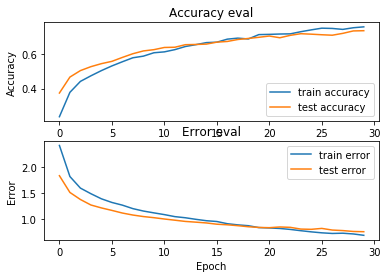

2499/2499 - 1s - loss: 0.8239 - accuracy: 0.7171

Test accuracy: 0.71708685
Target: 1, Predicted label: [1]


In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "data.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



# EXPERIMENT 3

* MODEL 3:

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_129 (Conv2D)          (None, 106, 11, 32)       320       
_________________________________________________________________
max_pooling2d_104 (MaxPoolin (None, 53, 6, 32)         0         
_________________________________________________________________
batch_normalization_104 (Bat (None, 53, 6, 32)         128       
_________________________________________________________________
conv2d_130 (Conv2D)          (None, 51, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_105 (MaxPoolin (None, 26, 2, 32)         0         
_________________________________________________________________
batch_normalization_105 (Bat (None, 26, 2, 32)         128       
_________________________________________________________________
conv2d_131 (Conv2D)          (None, 25, 1, 32)       

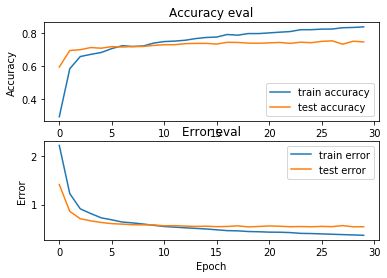

2046/2046 - 1s - loss: 0.5229 - accuracy: 0.7512

Test accuracy: 0.7512219
Target: 0, Predicted label: [0]


In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "sick_sound.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[0]
    y_to_predict = y_test[0]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



### PLOTING CONFUSION MATRIX

In [0]:
from sklearn.metrics import confusion_matrix

yhat_probs = model.predict(X_test, verbose=0)
tt = np.argmax(yhat_probs, axis = 1)

cm=confusion_matrix(y_test, tt)
print(cm)

[[ 126 1216]
 [  28  676]]


# Experiment : 4 
* MODEL 4 

Model: "sequential_64"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_191 (Conv2D)          (None, 108, 13, 64)       640       
_________________________________________________________________
max_pooling2d_139 (MaxPoolin (None, 54, 7, 64)         0         
_________________________________________________________________
batch_normalization_165 (Bat (None, 54, 7, 64)         256       
_________________________________________________________________
conv2d_192 (Conv2D)          (None, 54, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_140 (MaxPoolin (None, 27, 4, 64)         0         
_________________________________________________________________
batch_normalization_166 (Bat (None, 27, 4, 64)         256       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 27, 4, 32)       

Epoch 20/50
4864/4909 [============================>.] - ETA: 0s - loss: 0.3414 - accuracy: 0.9194
Epoch 00020: val_loss did not improve from 0.60048
4909/4909 [==============================] - 24s 5ms/sample - loss: 0.3417 - accuracy: 0.9189 - val_loss: 0.6661 - val_accuracy: 0.8005
Epoch 21/50
4864/4909 [============================>.] - ETA: 0s - loss: 0.3435 - accuracy: 0.9147
Epoch 00021: val_loss did not improve from 0.60048
4909/4909 [==============================] - 26s 5ms/sample - loss: 0.3438 - accuracy: 0.9149 - val_loss: 0.6717 - val_accuracy: 0.7989
Epoch 22/50
4864/4909 [============================>.] - ETA: 0s - loss: 0.3396 - accuracy: 0.9180
Epoch 00022: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00022: val_loss did not improve from 0.60048
4909/4909 [==============================] - 27s 5ms/sample - loss: 0.3390 - accuracy: 0.9185 - val_loss: 0.6755 - val_accuracy: 0.7980
Epoch 23/50
4864/4909 [============================>.] - ETA

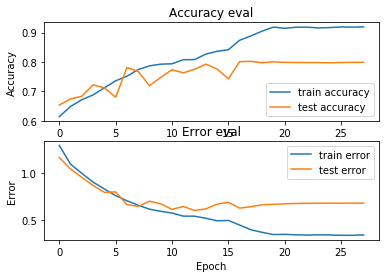

2046/2046 - 2s - loss: 0.6003 - accuracy: 0.7805

Test accuracy: 0.7805474
Target: 0, Predicted label: [0]


In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
# import tensorflow.keras as keras
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pylab as plt

DATA_PATH = "sick_sound.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), padding='same', activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(64, (2, 2), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
    # 4th conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), padding='same', activation='relu'))
    model.add(keras.layers.BatchNormalization())
    
#     base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
#                                                include_top=False,
#                                                weights='imagenet')
    
#     base_model.trainable = False
    
#     model = tf.keras.Sequential([
#         base_model,
#         tf.keras.layers.Dense(112, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
#     feature_extractor = hub.KerasLayer(URL,
#                                    input_shape= input_shape)
    
#     feature_extractor.trainable = False
    
    
#     model = tf.keras.Sequential([
#         feature_extractor,
#         tf.keras.layers.Dense(112, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.Dropout(0.3),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='softmax'))

    return model



def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)
    
#     lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
#       0.001,
#       decay_steps=STEPS_PER_EPOCH*1000,
#       decay_rate=1,
#       staircase=False
#     )

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                    min_delta=0.0001, cooldown=0 #, min_lr=0.001
                )
    
    earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights = True, verbose=1)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
            "sickweight4.h5", monitor='val_loss', verbose=1, save_best_only=True,
            save_weights_only=True, mode='min', save_freq='epoch' 
        )

    callbacks = [reduce_lr, earlystop, checkpoint]
    
    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()
    
    batch_size = 64
    # train model
    history = model.fit(X_train,
                        y_train,
                        batch_size=batch_size,
                        steps_per_epoch = int(np.ceil(len(X_train) / float(batch_size))), #  len(X_train) // batch_size,
                        validation_data=(X_validation, y_validation),
                        validation_steps= int(np.ceil(len(X_validation) / float(batch_size))),
                        epochs=50,
                        callbacks=callbacks,
                       )

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[0]
    y_to_predict = y_test[0]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



In [0]:
# DOING MANUAL PREDICTIONS:

input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

X_to_predict = X_test[12]
y_to_predict = y_test[12]

predict(model, X_to_predict, y_to_predict)


Target: 1, Predicted label: [1]


In [0]:
# PLOTTING CONFUSION MATRIX

from sklearn.metrics import confusion_matrix

yhat_probs = model.predict(X_test, verbose=0)
tt = np.argmax(yhat_probs, axis = 1)

cm=confusion_matrix(y_test, tt)
print(cm)

[[ 126 1216]
 [  28  676]]


# ALERT
### BELOW IS THE TESTING AREA, DON't TRY TO RUN THAT CODE.

MFCC vector (25, 197, 13)
(14, 197, 13, 1)
(4, 197, 13, 1)
(7, 197, 13, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 195, 11, 32)       320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 98, 6, 32)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 6, 32)         128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 4, 32)         9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 2, 32)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 2, 32)         128       
_______________________________________________

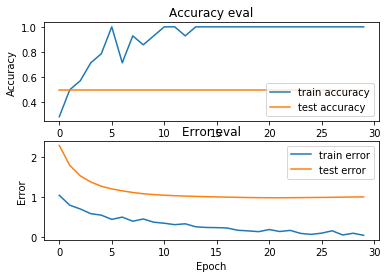

7/7 - 0s - loss: 1.0458 - accuracy: 0.2857

Test accuracy: 0.2857143
Target: 1, Predicted label: [0]


In [0]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

DATA_PATH = "breath_sound.json"


def load_data(data_path):
    """Loads training dataset from json file.

        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs

        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.

    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split

    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)
    print("MFCC vector", X.shape)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    print(X_train.shape)
    X_validation = X_validation[..., np.newaxis]
    print(X_validation.shape)
    X_test = X_test[..., np.newaxis]
    print(X_test.shape)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(2, activation='sigmoid'))
    # is me problem hau blc sigmoid hamesha ak hi single output deta hai so dense should be 1. 

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model

    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimizer = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[0]
    y_to_predict = y_test[0]

    # predict sample
    predict(model, X_to_predict, y_to_predict)



In [0]:
X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

X_to_predict = X_test[6]
y_to_predict = y_test[6]

predict(model, X_to_predict, y_to_predict)


(14, 197, 13, 1)
(4, 197, 13, 1)
(7, 197, 13, 1)
Target: 1, Predicted label: [1]


In [0]:
# HERE 197 is the total no of windows. and in every window we have 512 sample points,
# which is our window size as well. 13 are the total no of coefficients
# 14 is the total no of sample audio/tracks.

In [0]:
print("HERE 197 is the total no of windows. and in every window we have 512 sample points, which is our window size as well. \n13 are the no of coefficients")

HERE 197 is the total no of windows. and in every window we have 512 sample points, which is our window size as well. 
13 are the no of coefficients
